# TP Final TDA2

## Importaciones

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

from social_networks_utils_main import embeddings
from social_networks_utils_main import modelos
from social_networks_utils_main import metricas
from social_networks_utils_main.motifs import calculos
from social_networks_utils_main.motifs import graficos
from social_networks_utils_main.motifs import load
from social_networks_utils_main import homofilia

import Propietario

para ejecutar graphrole
pip install graphrole
ejecutar en python 3.9

In [2]:
from graphrole import RecursiveFeatureExtractor, RoleExtractor

falla en grafo aleatorio

In [21]:
import time
from social_networks_utils_main import logger
LOG = logger.Logger(logger.LogLevel.INFO)

def motif_grafo_eleatorios_b(grafo,n_motifs, iters=100):
    """
    La funcion calcula baselines para luego hacer comparaciones de motifs
    :param generador_baseline: Una función sin parámetros (supplier) que devuelve un modelo
    aleatorizado (ver el módulo modelos.py)
    :param conjuntos_motifs: Conjuntos de motifs a calcular las metrias. Se debe reibir una
    lista de listas: [ [MOTIFS_2_VERTICES], [MOTIFS_3_VERTICES], ... ], dado que el calculo
    para cada motif se hace en funcion de la cantidad de nodos, como indica en #calcular_motifs_en_paralelo
    :param iters: cantidad de iteraciones a realizar
    :return: los promedios y desvios estándar de cada motif
    """
    conteos = []
    t = time.time()
    for i in range(iters):
        LOG.info("Iteracion {}".format(i + 1) + (("; anterior: {:.2f} segs".format(time.time() - t)) if i > 0 else ""))
        t = time.time()
        g = modelos.configuration_model(metricas.distribucion_grados(grafo))
        LOG.debug("Grafo generado, vamos por motifs")
        conteos.append(calculos.calcular_motifs(g, n_motifs))
        LOG.debug(conteos[-1])

    valores = np.array(conteos)
    promedios = np.mean(valores, axis=0)
    stds = np.std(valores, axis=0)
    return promedios, stds

## Dataset

In [3]:
fronteras_reales = pd.read_csv('fronteras_terrestres_del_mundo.csv')
fronteras_reales

,País o territorio(Territorios sin soberanía plena en cursiva),Países o territorios vecinos(Territorios sin soberanía plena en cursiva)
0,China,Afganistán
1,China,Bután
2,China,Birmania
3,China,Corea del Norte
4,China,India
...,...,...
636,Dinamarca,Alemania
637,Catar,Arabia Saudita
638,San Marino,Italia
639,Mónaco,Francia


In [4]:
fronteras_TEG = pd.read_csv('paisesFronteraTeg.csv')
fronteras_TEG

,Pais,frontera,tipo
0,Canada,Newfoundland (island)|Terranova,terrestre
1,Canada,New York (state)|New York,terrestre
2,Canada,Oregon,terrestre
3,Canada,Yukon,terrestre
4,Yukon,Alaska,terrestre
...,...,...,...
84,Madagascar,Zaire,marina
85,Zaire,South Africa,terrestre
86,Sumatra,Australia,marina
87,Borneo,Australia,marina


In [5]:
paises_TEG = pd.read_csv('paisesTEG.csv')
paises_TEG

,Pais,Continente,Categoria
0,Canada,North America,canon
1,Yukon,North America,globo
2,Alaska,North America,barco
3,Greenland,North America,globo
4,Oregon,North America,canon
5,California,North America,canon
6,Mexico,North America,canon
7,New York (state)|New York,North America,barco
8,Newfoundland (island)|Terranova,North America,canon
9,Labrador,North America,canon


## Transcripcion a grafos

### fronteras reales

En el data set de fronteras reales solo se tienen e cuenta las fronteras terrestres.

In [6]:
mundo_real = nx.Graph()
for fila in fronteras_reales.iterrows():
    territorio1 = fila[1]['País o territorio(Territorios sin soberanía plena en cursiva)']
    territorio2 = fila[1]['Países o territorios vecinos(Territorios sin soberanía plena en cursiva)']
    if not mundo_real.has_node(territorio1):
        mundo_real.add_node(territorio1)
    if not mundo_real.has_node(territorio2):
        # existen mas territorios en los paises vecinos ya que no todos se repiten
        mundo_real.add_node(territorio2)
    if mundo_real.has_edge(territorio2, territorio1):
        # evita los repetidos
        continue
    mundo_real.add_edge(territorio1, territorio2)

print(mundo_real.number_of_nodes())
print(mundo_real.number_of_edges())

163
325


existen 2 conjuntos conexos

In [7]:
nx.number_connected_components(mundo_real)

2

haciendo una busqueda se encontro que 'Haití' y 'República Dominicana' son los unicos 2 paises que solo estan conectados entre si por lo que se decidio sacarlos

In [8]:
for i in mundo_real:
    h = nx.node_connected_component(mundo_real, i)
    if len(h) > 10:#si la componente hubiese sido mas grande se hubiera planteado unificarlas
        continue
    print(h)

{'República Dominicana', 'Haití'}
{'República Dominicana', 'Haití'}


In [9]:
mundo_real.remove_node('Haití')
mundo_real.remove_node('República Dominicana')
mundo_real.number_of_nodes()

161

### datos TEG

In [10]:
listado_de_propietarios = Propietario.obtener_orden_de_turnos_de_jugadores()
listado_de_orden_de_paises_TEG = Propietario.obtener_orden_de_propietarios()

In [11]:
mundo_TEG = nx.Graph()
for fila_de_datos in paises_TEG.iterrows():
    propietario_actual = listado_de_orden_de_paises_TEG[mundo_TEG.number_of_nodes()]
    mundo_TEG.add_node(fila_de_datos[1]['Pais'], continente=fila_de_datos[1]['Continente'], categoria=fila_de_datos[1]['Categoria'], propietario=Propietario.Propietario_TEG(propietario_actual))
mundo_TEG.number_of_nodes()

50

In [12]:
for fila in fronteras_TEG.iterrows():
    territorio1 = fila[1]['Pais']
    territorio2 = fila[1]['frontera']
    tipo = fila[1]['tipo']
    mundo_TEG.add_edge(territorio1, territorio2, tipo=tipo)
mundo_TEG.number_of_edges()

89

## Grafos aleatorios

In [13]:
# cantidades que mas se hacemejan al TEG
cantidad_de_nodos = 50
cantidad_de_aristas = 90

def generar_grafo_erdy(alpha = 0.5, rango_de_error = 0.05, iteraciones_max = 20):
    for i in range(iteraciones_max):
        grafo_erdy = modelos.erdos_renyi(cantidad_de_nodos, cantidad_de_aristas/(alpha * cantidad_de_nodos))
        if nx.number_connected_components(grafo_erdy) > 1:
            continue
        if grafo_erdy.number_of_edges() > cantidad_de_aristas * (1 + rango_de_error):
            continue
        if grafo_erdy.number_of_edges() < cantidad_de_aristas * (1 - rango_de_error):
            continue
        return grafo_erdy
    print("falla al crear grafo")
    return grafo_erdy

def generar_grafo_pot(alpha = 1, rango_de_error = 0.05, iteraciones_max = 20):
    for i in range(iteraciones_max):
        grafo_pot = modelos.preferential_attachment(False, 2, cantidad_de_nodos, cantidad_de_aristas/ (alpha * cantidad_de_nodos))
        if nx.number_connected_components(grafo_pot) > 1:
            continue
        if grafo_pot.number_of_edges() > cantidad_de_aristas * (1 + rango_de_error):
            continue
        if grafo_pot.number_of_edges() < cantidad_de_aristas * (1 - rango_de_error):
            continue
        return grafo_pot
    print("falla al crear grafo")
    return grafo_pot

In [14]:
grafo_erdy = generar_grafo_erdy()
grafo_erdy.number_of_nodes(), grafo_erdy.number_of_edges()

(50, 88)

In [15]:
grafo_pot = generar_grafo_pot(alpha=0.75)
grafo_pot.number_of_nodes(), grafo_pot.number_of_edges()

(50, 94)

## Comparaciones

In [24]:
def distancia_media(excentricidad_del_grafo):
    nodos = excentricidad_del_grafo.keys()
    distancia_media = 0
    for nodo in nodos:
        distancia_media += excentricidad_del_grafo[nodo]
    return distancia_media / len(excentricidad_del_grafo)

def distribucion_de_valores(diccionario_de_valores_grafo):
    nodos = diccionario_de_valores_grafo.keys()
    max = 0
    for nodo in nodos:
        distancia = diccionario_de_valores_grafo[nodo]
        if max < distancia:
            max = distancia
    grados = [0] * (max + 1)
    for nodo in nodos:
        distancia = diccionario_de_valores_grafo[nodo]
        grados[distancia] += 1
    return np.array(grados)

def datos_varios(grafo, imprimir = False):
    diametro = nx.diameter(grafo)
    clustering = metricas.clustering(grafo)
    grado_prom = metricas.grado_promedio(grafo)
    distribucion_distancias = nx.eccentricity(grafo)
    distancia = distancia_media(distribucion_distancias)
    if imprimir:
        print("nodos: ", grafo.number_of_nodes())
        print("aristas: ", grafo.number_of_edges())
        print("clustering: ", clustering)
        print("diametro: ", diametro)
        print("distancia media: ", distancia)
        print("grado promedio: ", grado_prom)
        # nx.draw_networkx(grafo,node_size = 10,with_labels=False,alpha=0.75)
    return grado_prom, metricas.distribucion_grados(grafo), diametro, clustering, distancia, distribucion_de_valores(distribucion_distancias)

In [17]:
def imprimir_datos(distribuciones, titulo, tipo, log=False):
    # rango = np.arange(len(distribucion))
    for distribucion in distribuciones:
        plt.plot(distribucion[1], label=distribucion[0])

    # Para obtener el valor de alfa vistualmente
    # x_m = 4
    # alpha_prima = 1.7
    # exponencial = list(map(lambda k: 5 * k ** (-alpha_prima), rango[x_m:]))
    # plt.plot(rango[x_m:], exponencial)
    # print("Alfa: ", alpha_prima + 1)

    plt.xlabel(tipo)
    plt.ylabel("cantidad")
    if log:
        plt.xscale("log")
        plt.yscale("log")
    plt.title(titulo)
    plt.legend()
    plt.show()

def imprimir_graficos(distribucion):
    titulo_grado = "Distribucion de grado"
    titulo_distancia = "Distribucion de distancia"
    titulo_cluster = "Distribucion de clustering"
    grado = []
    distancia = []
    cluster = []
    for (nombre, datos) in distribucion.items():
        grado.append([nombre, datos[0]])
        distancia.append([nombre, datos[1]])
        cluster.append([nombre, datos[2]])
    imprimir_datos(grado, titulo_grado, "grado")
    imprimir_datos(grado, titulo_grado, "grado", log=True)
    imprimir_datos(distancia, titulo_distancia, "distancia")
    imprimir_datos(cluster, titulo_cluster, "cluster")


In [18]:
def imprimir_comparaciones(d_grafos):
    distribucion = {}
    print("\\begin{center}")
    print("\\begin{tabular}{| c | c | c | c | c |}")
    print("\t\\hline")
    print("\tTipo de grafo & Grado prom & Diametro & Distancia media & Clustering \\\\ \\hline")
    for (nombre, grafo) in d_grafos.items():
        grado_prom, distribucion_grado, diametro, clustering, distancia, distribucion_por_distancia = datos_varios(grafo)
        distribucion[nombre] = [distribucion_grado, distribucion_por_distancia, clustering[0]]
        print("\t", nombre, " & ", round(grado_prom, 2), " & ", diametro, " & ", round(distancia, 2), " & ", round(clustering[1], 2), "\\\\")
    print("\t\\hline")
    print("\\end{tabular}")
    print("\\end{center}")
    imprimir_graficos(distribucion)

def ejecutar_comparaciones():
    d_grafos = {}
    d_grafos['TEG'] = mundo_TEG
    d_grafos['mundo real'] = mundo_real
    d_grafos['erdy'] = grafo_erdy
    d_grafos['potencia'] = grafo_pot
    imprimir_comparaciones(d_grafos)

\begin{center}
\begin{tabular}{| c | c | c | c | c |}
	\hline
	Tipo de grafo & Grado prom & Diametro & Distancia media & Clustering \\ \hline
	 TEG  &  3.56  &  9  &  7.06  &  0.38 \\
	 mundo real  &  4.02  &  21  &  15.17  &  0.48 \\
	 erdy  &  3.52  &  6  &  5.06  &  0.06 \\
	 potencia  &  3.76  &  5  &  4.62  &  0.06 \\
	\hline
\end{tabular}
\end{center}


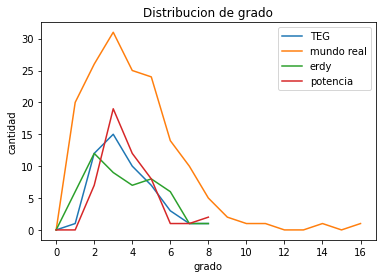

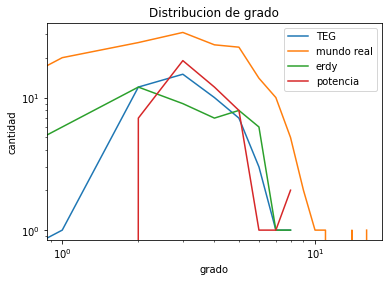

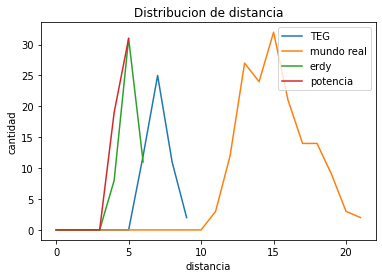

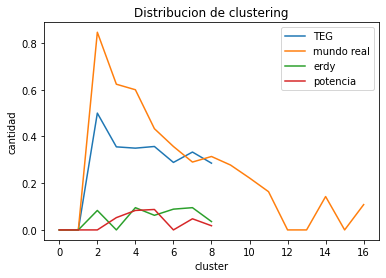

In [19]:
ejecutar_comparaciones()

### Centralidad

In [66]:
def imprimir_datos_histograma(distribuciones, titulo, tipo):
    # rango = np.arange(len(distribucion))
    for distribucion in distribuciones:
        plt.hist(distribucion[1], label=distribucion[0], alpha = 0.75)
    plt.xlabel(tipo)
    plt.ylabel("cantidad")
    plt.title(titulo)
    plt.legend()
    plt.show()

def imprimir_graficos_centralidad(distribucion):
    # rango_max_grado = 0
    # nodos_max_grados = []
    # rango_max_eigenvector = 0
    # nodos_max_eigenvector = []
    # rango_max_closeness = 0
    # nodos_max_closeness = []
    titulo_grado = "Distribucion de centralidad (grado)"
    titulo_eigenvector = "Distribucion de centralidad (eigenvector)"
    titulo_betweenness = "Distribucion de centralidad (betweenness)"
    titulo_closeness = "Distribucion de centralidad (closeness)"
    grado = []
    distancia = []
    betweenness = []
    cluster = []
    for (nombre, datos) in distribucion.items():
        grado.append([nombre, datos[0]])
        distancia.append([nombre, datos[1]])
        betweenness.append([nombre, datos[2]])
        cluster.append([nombre, datos[3]])
    imprimir_datos_histograma(grado, titulo_grado, "grado")
    imprimir_datos_histograma(distancia, titulo_eigenvector, "eigenvector")
    imprimir_datos_histograma(distancia, titulo_betweenness, "betweenness")
    imprimir_datos_histograma(cluster, titulo_closeness, "closeness")

def imprimir_mas_centrales(d_nodos, tipo, nombre):
    max = 0
    n_max = []
    for (nodo, centralidad) in d_nodos.items():
        if max < centralidad:
            max = centralidad
            n_max = [nodo]
        elif max == centralidad:
            n_max.append(nodo)
    print("centralidad de ", tipo, "grafo: ", nombre, "Centralidad: ", max, "nodos: ", n_max)

def centralidad_de_grafo(d_grafos):
    d_centralidad = {}
    for (nombre, grafo) in d_grafos.items():
        lista = []
        centralidad_de_grado = nx.degree_centrality(grafo)
        centralidad_de_eigenvector = nx.eigenvector_centrality_numpy(grafo)
        centralidad_de_betweenness = nx.betweenness_centrality(grafo)
        centralidad_de_closeness = nx.closeness_centrality(grafo)
        lista.append(centralidad_de_grado.values())
        lista.append(centralidad_de_eigenvector.values())
        lista.append(centralidad_de_betweenness.values())
        lista.append(centralidad_de_closeness.values())
        d_centralidad[nombre] = lista
        imprimir_mas_centrales(centralidad_de_grado, "grado", nombre)
        imprimir_mas_centrales(centralidad_de_eigenvector, "eigenvector", nombre)
        imprimir_mas_centrales(centralidad_de_betweenness, "betweenness", nombre)
        imprimir_mas_centrales(centralidad_de_closeness, "closeness", nombre)
    imprimir_graficos_centralidad(d_centralidad)

def ejecutar_comparaciones_centralidad():
    d_grafos = {}
    d_grafos['TEG'] = mundo_TEG
    d_grafos['mundo real'] = mundo_real
    d_grafos['erdy'] = grafo_erdy
    d_grafos['potencia'] = grafo_pot
    centralidad_de_grafo(d_grafos)

centralidad de  grado grafo:  TEG Centralidad:  0.16326530612244897 nodos:  ['China']
centralidad de  eigenvector grafo:  TEG Centralidad:  0.4119119682483943 nodos:  ['China']
centralidad de  betweenness grafo:  TEG Centralidad:  0.21783257134022432 nodos:  ['Iran']
centralidad de  closeness grafo:  TEG Centralidad:  0.3141025641025641 nodos:  ['Iran']
centralidad de  grado grafo:  mundo real Centralidad:  0.1 nodos:  ['China']
centralidad de  eigenvector grafo:  mundo real Centralidad:  0.3858913041226459 nodos:  ['Rusia']
centralidad de  betweenness grafo:  mundo real Centralidad:  0.3899001540663615 nodos:  ['Francia']
centralidad de  closeness grafo:  mundo real Centralidad:  0.201765447667087 nodos:  ['Francia']
centralidad de  grado grafo:  erdy Centralidad:  0.16326530612244897 nodos:  [45]
centralidad de  eigenvector grafo:  erdy Centralidad:  0.27788862798875896 nodos:  [19]
centralidad de  betweenness grafo:  erdy Centralidad:  0.2739289763524458 nodos:  [45]
centralidad de 

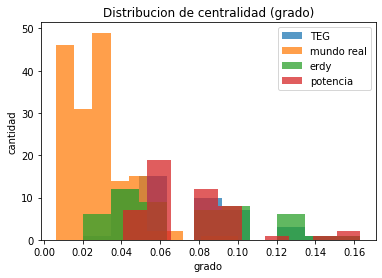

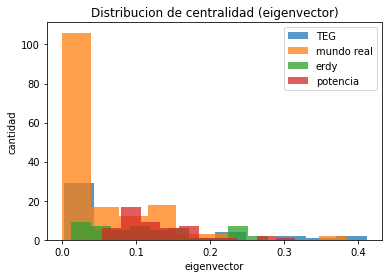

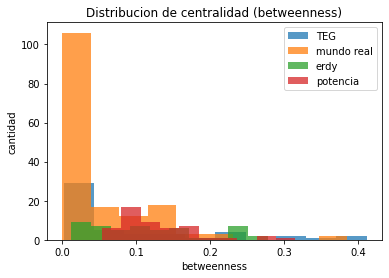

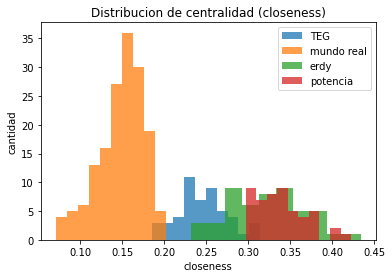

In [67]:
ejecutar_comparaciones_centralidad()

## comunidades

## homofilia

## Cambio de dueño

In [8]:
def cantidad_de_paises_por_continente():
    resultado = {}
    for continente in paises_TEG['Continente'].unique():
        resultado[continente] = 0
    for continente in paises_TEG['Continente']:
        resultado[continente] += 1
    return resultado
paises_de_continentes_TEG = cantidad_de_paises_por_continente()
paises_de_continentes_TEG

{'North America': 10,
 'Europe': 9,
 'Asia': 15,
 'South America': 6,
 'Africa': 6,
 'Oceania': 4}

In [9]:
def paises_que_pertenecen_al_jugador(jugador, TEG):
    resultado = []
    for nodo in TEG.nodes:
        pais = TEG.nodes[nodo]
        # print(pais)
        if pais['propietario'].propietario_actual() == jugador:
            resultado.append(nodo)
    return resultado

def pais_es_fronterizo(pais, TEG):
    jugador_propietario = TEG.nodes[pais]['propietario'].propietario_actual()
    for adyacentes in TEG.neighbors(pais):
        if jugador_propietario != TEG.nodes[adyacentes]['propietario'].propietario_actual():
            return True
    return False

def paises_que_pueden_atacar(jugador, TEG):
    paises_atacantes_del_jugador = []
    for pais in paises_que_pertenecen_al_jugador(jugador, TEG):
        if pais_es_fronterizo(pais, TEG) and TEG.nodes[pais]['propietario'].puede_atacar():
            paises_atacantes_del_jugador.append(pais)
    return paises_atacantes_del_jugador

def cantidad_de_nuevos_ejercitos(jugador, TEG):
    total = len(paises_que_pertenecen_al_jugador(jugador, TEG)) // 2
    if total < 3:
        total = 3
    return total

def triunfo(jugador, TEG):
    return len(paises_que_pertenecen_al_jugador(jugador, TEG)) >= 30

def paises_a_reforzar(jugador, refuerzos, TEG):
    paises_posibles_a_reforzar = paises_que_pertenecen_al_jugador(jugador, TEG)
    if len(paises_posibles_a_reforzar) == 0:
        return []
    listado_probabilistico = []
    resultado = []
    for pais in paises_posibles_a_reforzar:
        if not pais_es_fronterizo(pais, TEG):
            continue
        for adyacentes in TEG.neighbors(pais):
            listado_probabilistico += [pais] * TEG.nodes[adyacentes]['propietario'].cantidad_de_ejercitos()
    # print(listado_probabilistico)
    random.shuffle(listado_probabilistico)
    for refuerzo in range(refuerzos):
        if len(listado_probabilistico) == 1:
            pais = paises_posibles_a_reforzar[0]
        else:
            pais = listado_probabilistico[random.randint(0, len(listado_probabilistico)-1)]
        resultado.append(pais)
    return resultado

def reforzar_paises(jugador, refuerzos, TEG):
    paises = paises_a_reforzar(jugador, refuerzos, TEG)
    if len(paises) == 0:
        return
    for pais in paises:
        TEG.nodes[pais]['propietario'].reforzar(1)

def paises_que_puede_atacar(pais, TEG):
    resultado = []
    jugador_propietario = TEG.nodes[pais]['propietario'].propietario_actual()
    for adyacente in TEG.neighbors(pais):
        if jugador_propietario == TEG.nodes[adyacente]['propietario'].propietario_actual():
            continue
        resultado.append(adyacente)
    return resultado

def continentes_controlados_por_el_jugador(jugador, valor_continentes, TEG):
    continentes = {}
    resultado = []
    for pais in paises_que_pertenecen_al_jugador(jugador, TEG):
        continente = TEG.nodes[pais]['continente']
        if continente in continentes.keys():
            continentes[continente] += 1
        else:
            continentes[continente] = 0
    for continente in continentes.keys():
        if continentes[continente] == valor_continentes[continente]:
            resultado.append(continente)
    return resultado

def ejercitos_continentales(continentes_controlados):
    continentes = {'North America': 5, 'Europe': 5, 'Asia': 7, 'South America': 3, 'Africa': 3, 'Oceania': 2}
    cantidad_extra = 0
    for cotinente in continentes_controlados:
        cantidad_extra += continentes[cotinente]
    return cantidad_extra

In [10]:
def inicio_de_juego(jugadores, TEG):
    for jugador in jugadores:
        reforzar_paises(jugador, 5, TEG)
    for jugador in jugadores:
        reforzar_paises(jugador, 3, TEG)
    return

def fase_refuerzos(jugador, TEG):
    refuerzos = cantidad_de_nuevos_ejercitos(jugador, TEG)
    continentes_controlados = continentes_controlados_por_el_jugador(jugador, paises_de_continentes_TEG, TEG)#hardcodeado "paises_de_continentes_TEG"
    refuerzos += ejercitos_continentales(continentes_controlados)
    reforzar_paises(jugador, refuerzos, TEG)

def fase_ataque(jugador, TEG):
    atacantes = paises_que_pueden_atacar(jugador, TEG)
    while len(atacantes) > 0:
        for pais in atacantes:
            defensores = paises_que_puede_atacar(pais, TEG)
            while pais_es_fronterizo(pais, TEG) and TEG.nodes[pais]['propietario'].puede_atacar():
                if len(defensores) == 1:
                    defensor = defensores[0]
                else:
                    defensor = defensores[random.randint(0, len(defensores)-1)]
                TEG.nodes[defensor]['propietario'].defender(TEG.nodes[pais]['propietario'])
        atacantes = paises_que_pueden_atacar(jugador, TEG)

def fase_reagrupamiento(jugador, TEG):
    ejercitos_a_reposicionar = 0
    for pais in paises_que_pertenecen_al_jugador(jugador, TEG):
        if not pais_es_fronterizo(pais, TEG) and TEG.nodes[pais]['propietario'].puede_atacar():
            exceso = TEG.nodes[pais]['propietario'].cantidad_de_ejercitos() - 1
            ejercitos_a_reposicionar += exceso
            TEG.nodes[pais]['propietario'].desplazar(exceso)
    reforzar_paises(jugador, ejercitos_a_reposicionar, TEG)


In [98]:
def rondas_por_turnos_TEG(jugadores, TEG, primer_turno=False):
    for jugador in jugadores:
        print("Ronda del jugador: ", jugador)
        if len(paises_que_pertenecen_al_jugador(jugador, TEG)) == 0:
            print("jugador perdio.")
            continue
        if not primer_turno:
            fase_refuerzos(jugador, TEG)
        fase_ataque(jugador, TEG)
        if triunfo(jugador, TEG):
            #No nesesita mantener los 30 paises solo conquistarlos
            print("jugador: ", jugador, " es el ganador.")
            return True
        fase_reagrupamiento(jugador, TEG)
    return False

def partida_de_TEG(lista_de_jugadores, TEG, estadisticas, turnos_maximos=100):
    inicio_de_juego(lista_de_jugadores, TEG)
    turno = 1
    victoria = False
    while turno <= turnos_maximos and not victoria:
        print("Turno: ", turno)
        victoria = rondas_por_turnos_TEG(lista_de_jugadores, TEG, turno==1)
        if victoria:
            print("Fin del juego")
            continue
        print("estado actual:")
        for jugador in listado_de_propietarios:
            cantidad = len(paises_que_pertenecen_al_jugador(jugador, mundo_TEG))
            print("    ", jugador, cantidad)
            estadisticas[jugador].append(cantidad)
        turno += 1
    if not victoria:
        print("se acabaron los turnos, no hay ganadores.")
    return turno


In [150]:
print(listado_de_propietarios)
estadisticas = {}
paises_iniciales = {}
for jugador in listado_de_propietarios:
    estadisticas[jugador] = []
    estadisticas[jugador].append(len(paises_que_pertenecen_al_jugador(jugador, mundo_TEG)))
    paises_iniciales[jugador] = paises_que_pertenecen_al_jugador(jugador, mundo_TEG)
turnofinal = partida_de_TEG(listado_de_propietarios, mundo_TEG, estadisticas)

['Negro', 'Rojo', 'Verde', 'Amarillo', 'Magenta', 'Azul']
Turno:  1
Ronda del jugador:  Negro
Ronda del jugador:  Rojo
Ronda del jugador:  Verde
Ronda del jugador:  Amarillo
Ronda del jugador:  Magenta
Ronda del jugador:  Azul
estado actual:
     Negro 7
     Rojo 10
     Verde 8
     Amarillo 9
     Magenta 7
     Azul 9
Turno:  2
Ronda del jugador:  Negro
Ronda del jugador:  Rojo
Ronda del jugador:  Verde
Ronda del jugador:  Amarillo
Ronda del jugador:  Magenta
Ronda del jugador:  Azul
estado actual:
     Negro 6
     Rojo 12
     Verde 10
     Amarillo 8
     Magenta 6
     Azul 8
Turno:  3
Ronda del jugador:  Negro
Ronda del jugador:  Rojo
Ronda del jugador:  Verde
Ronda del jugador:  Amarillo
Ronda del jugador:  Magenta
Ronda del jugador:  Azul
estado actual:
     Negro 6
     Rojo 12
     Verde 11
     Amarillo 8
     Magenta 6
     Azul 7
Turno:  4
Ronda del jugador:  Negro
Ronda del jugador:  Rojo
Ronda del jugador:  Verde
Ronda del jugador:  Amarillo
Ronda del jugador:  Magent

In [151]:
print(turnofinal)

11


In [152]:
estadisticas

{'Negro': [8, 7, 6, 6, 8, 8, 10, 8, 5, 3, 2],
 'Rojo': [8, 10, 12, 12, 12, 14, 14, 16, 19, 20, 24],
 'Verde': [9, 8, 10, 11, 10, 9, 9, 11, 11, 11, 9],
 'Amarillo': [8, 9, 8, 8, 7, 7, 5, 4, 3, 4, 3],
 'Magenta': [8, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6],
 'Azul': [9, 9, 8, 7, 7, 6, 5, 5, 6, 6, 6]}

In [153]:
paises_iniciales

{'Negro': ['Yukon',
  'Oregon',
  'Mexico',
  'Spain',
  'Sweden',
  'Aral Kazakhstan|Aral',
  'Tartary',
  'Argentina'],
 'Rojo': ['New York (state)|New York',
  'Russia',
  'India',
  'Taymyr Autonomous Okrug|Taymyr',
  'Kamchatka',
  'Siberia',
  'Gobi',
  'Israel'],
 'Verde': ['Canada',
  'Great Britain',
  'Iceland',
  'Poland',
  'China',
  'Ethiopia',
  'Zaire',
  'South Africa',
  'Java'],
 'Amarillo': ['Alaska',
  'Newfoundland (island)|Terranova',
  'Labrador',
  'Germany',
  'Italy',
  'Mongolia',
  'Malaysia',
  'Turkey'],
 'Magenta': ['Greenland',
  'California',
  'Iran',
  'Peru',
  'Colombia',
  'Chile',
  'Sahara',
  'Madagascar'],
 'Azul': ['France',
  'Arabia',
  'Japan',
  'Brazil',
  'Uruguay',
  'Egypt',
  'Sumatra',
  'Borneo',
  'Australia']}

In [109]:
paises_del_ganador = []
paises_de_los_perdedores = []

In [155]:
ganador = listado_de_propietarios[1]
perdedores = []
perdedores.append(listado_de_propietarios[5])
# perdedores.append(listado_de_propietarios[0])
print(ganador, perdedores)
listado_de_propietarios

Rojo ['Azul']


['Negro', 'Rojo', 'Verde', 'Amarillo', 'Magenta', 'Azul']

In [156]:
paises_del_ganador += paises_iniciales[ganador]
# for perdedor in perdedores:
#     paises_de_los_perdedores += paises_iniciales[ganador]
print(len(paises_del_ganador), len(paises_de_los_perdedores))

50 59


In [107]:
def graficar_estadisticas_TEG(estadisticas, titulo, log=False):
    colores = {'Magenta': 'magenta', 'Verde': 'green', 'Rojo': 'red', 'Negro': 'black', 'Azul': 'blue', 'Amarillo': 'yellow'}
    x_maximo = 0
    y_maximo = 0
    f = plt.figure()
    f.set_figwidth(16)
    f.set_figheight(8)
    for distribucion in estadisticas.keys():
        plt.plot(estadisticas[distribucion], label=distribucion, linewidth=2, alpha=0.75, color=colores[distribucion])
        maximo_alcanzado = max(estadisticas[distribucion])
        if x_maximo == 0:
            x_maximo = len(estadisticas[distribucion])
        if y_maximo < maximo_alcanzado:
            y_maximo = maximo_alcanzado
    plt.xlabel("Turno completado")
    plt.ylabel("Cantidad de paises")
    plt.xticks(np.arange(0, x_maximo, 1))
    plt.yticks(np.arange(0, y_maximo+1, 1))
    plt.margins(x=0, y=0)
    if log:
        plt.xscale("log")
        plt.yscale("log")
    plt.grid(color='r', linestyle='-', linewidth=1, alpha=0.05)
    plt.title(titulo)
    plt.legend()
    plt.show()

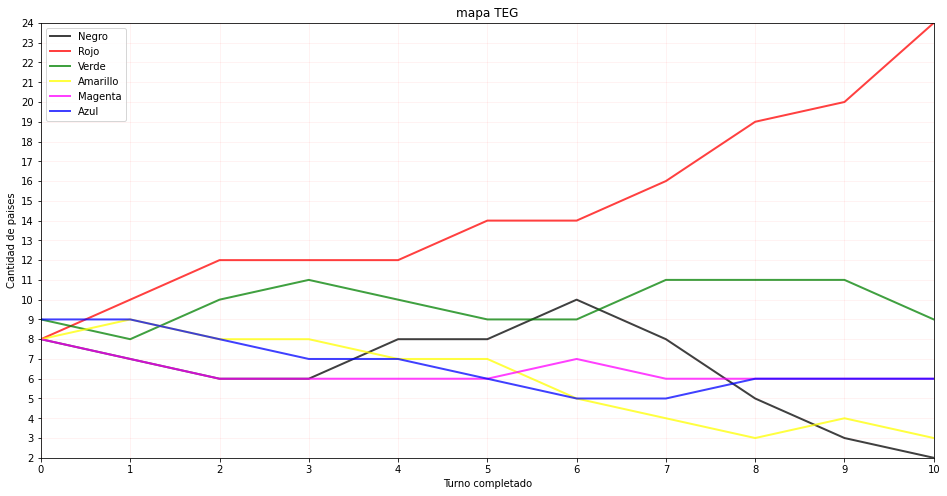

In [154]:
graficar_estadisticas_TEG(estadisticas, "mapa TEG")

In [149]:
#reiniciar tablero
listado_de_propietarios = Propietario.obtener_orden_de_turnos_de_jugadores()
listado_de_orden_de_paises_TEG = Propietario.obtener_orden_de_propietarios()
mundo_TEG = nx.Graph()
for fila_de_datos in paises_TEG.iterrows():
    propietario_actual = listado_de_orden_de_paises_TEG[mundo_TEG.number_of_nodes()]
    mundo_TEG.add_node(fila_de_datos[1]['Pais'], continente=fila_de_datos[1]['Continente'],
                       categoria=fila_de_datos[1]['Categoria'],
                       propietario=Propietario.Propietario_TEG(propietario_actual))
for fila in fronteras_TEG.iterrows():
    territorio1 = fila[1]['Pais']
    territorio2 = fila[1]['frontera']
    tipo = fila[1]['tipo']
    mundo_TEG.add_edge(territorio1, territorio2, tipo=tipo)
mundo_TEG.number_of_edges()

89

In [167]:
def paises_cantidades(lista_de_paises, mas_de, titulo):
    paises = {}
    for pais in lista_de_paises:
        if pais in paises.keys():
            paises[pais] += 1
        else:
            paises[pais] = 1
    maximo = 0
    print(titulo)
    print("\\begin{center}")
    print("\\begin{tabular}{| c | c |}")
    print("\\hline")
    print("\tpais & cantidad\\\\ \\hline")
    for pais in paises.keys():
        if mas_de > paises[pais]:
            continue
        print("\t", pais, " & ", paises[pais], "\\\\")
        if maximo < paises[pais]:
            maximo = paises[pais]
    print("\\hline")
    print("\\end{tabular}")
    print("\\end{center}")
    print("Maximo = ", maximo)

paises_cantidades(paises_de_los_perdedores, 3, "prededores")
paises_cantidades(paises_del_ganador, 3, "ganadores")

prededores
\begin{center}
\begin{tabular}{| c | c |}
\hline
	pais & cantidad\\ \hline
	 Russia  &  4 \\
	 Arabia  &  4 \\
	 India  &  5 \\
	 Iran  &  4 \\
	 France  &  4 \\
	 Gobi  &  4 \\
	 Japan  &  3 \\
\hline
\end{tabular}
\end{center}
Maximo =  5
ganadores
\begin{center}
\begin{tabular}{| c | c |}
\hline
	pais & cantidad\\ \hline
	 Gobi  &  3 \\
	 India  &  4 \\
	 Russia  &  3 \\
\hline
\end{tabular}
\end{center}
Maximo =  4


## Motif

In [14]:
mundo_TEG_terrestre = nx.Graph()

for fila_de_datos in paises_TEG.iterrows():
    mundo_TEG_terrestre.add_node(fila_de_datos[1]['Pais'], continente=fila_de_datos[1]['Continente'],
                       categoria=fila_de_datos[1]['Categoria'])
for fila in fronteras_TEG.iterrows():
    if fila[1]['tipo'] != 'terrestre':
        continue
    territorio1 = fila[1]['Pais']
    territorio2 = fila[1]['frontera']
    mundo_TEG_terrestre.add_edge(territorio1, territorio2)
mundo_TEG_terrestre.number_of_edges()

66

In [20]:
# import time
# import numpy as np
# from social_networks_utils_main import logger
# LOG = logger.Logger(logger.LogLevel.INFO)
#
# def motif_grafo_eleatorios_b(grafo,n_motifs, iters=100):
#     """
#     :return: los promedios y desvios estándar de cada motif
#     """
#     conteos = []
#     t = time.time()
#     for i in range(iters):
#         LOG.info("Iteracion {}".format(i + 1) + (("; anterior: {:.2f} segs".format(time.time() - t)) if i > 0 else ""))
#         t = time.time()
#         g = modelos.configuration_model(metricas.distribucion_grados(grafo))
#         LOG.debug("Grafo generado, vamos por motifs")
#         conteos.append(calculos.calcular_motifs(g, n_motifs))
#         LOG.debug(conteos[-1])
#
#     valores = np.array(conteos)
#     promedios = np.mean(valores, axis=0)
#     stds = np.std(valores, axis=0)
#     return promedios, stds

In [25]:
def signa_profile(grafo, n_motif=5, iteraciones=10):
    motif = calculos.calcular_motifs(grafo, n_motif)
    #print(motif)# debido a lo mucho que pueda demorar es conveniente guardar los datos
    promedio_motif,desvio_motif = motif_grafo_eleatorios_b(grafo, n_motif, iteraciones)
    signa_profile = calculos.significance_profile(motif, promedio_motif, desvio_motif)
    return signa_profile

Inicio comparaciones
Iteracion 1
Iteracion 2; anterior: 79.63 segs
Iteracion 3; anterior: 75.76 segs
Iteracion 4; anterior: 76.76 segs
Iteracion 5; anterior: 78.38 segs
Iteracion 6; anterior: 78.67 segs
Iteracion 7; anterior: 78.10 segs
Iteracion 8; anterior: 80.25 segs
Iteracion 9; anterior: 80.07 segs
Iteracion 10; anterior: 79.48 segs
Fin comparaciones
Inicio comparaciones
Iteracion 1
Iteracion 2; anterior: 78.69 segs
Iteracion 3; anterior: 79.30 segs
Iteracion 4; anterior: 78.68 segs
Iteracion 5; anterior: 78.62 segs
Iteracion 6; anterior: 77.58 segs
Iteracion 7; anterior: 78.24 segs
Iteracion 8; anterior: 78.26 segs
Iteracion 9; anterior: 78.16 segs
Iteracion 10; anterior: 78.85 segs
Fin comparaciones
Inicio comparaciones
Iteracion 1
Iteracion 2; anterior: 256.56 segs
Iteracion 3; anterior: 259.74 segs
Iteracion 4; anterior: 263.51 segs
Iteracion 5; anterior: 265.88 segs
Iteracion 6; anterior: 259.70 segs
Iteracion 7; anterior: 259.41 segs
Iteracion 8; anterior: 257.83 segs
Iterac

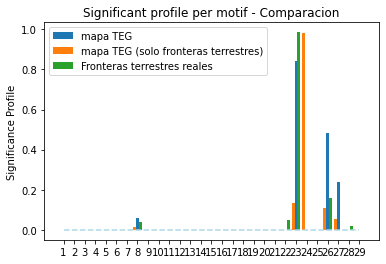

In [26]:
comparaciones = [[mundo_TEG, mundo_TEG_terrestre, mundo_real], ["mapa TEG", "mapa TEG (solo fronteras terrestres)", "Fronteras terrestres reales"], []]
for mapa in comparaciones[0]:
    print("Inicio comparaciones")
    comparaciones[2].append(signa_profile(mapa))
    print("Fin comparaciones")
graficos.graficar_significant_profiles_conjuntos(comparaciones[2], comparaciones[1], "Comparacion")

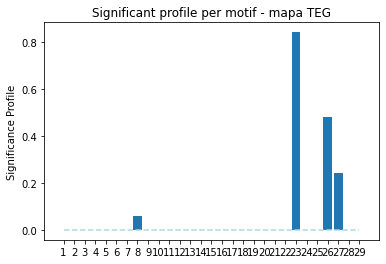

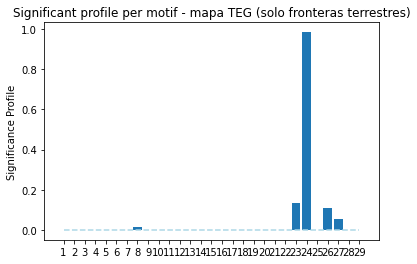

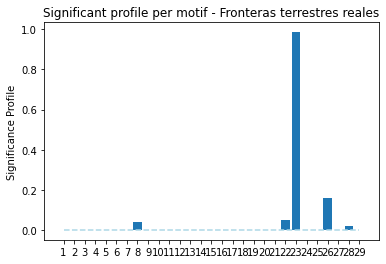

In [35]:
def graficar_individual_motif():
    for sig_prof in range(len(comparaciones[2])):
        graficos.graficar_significant_profile(comparaciones[2][sig_prof], comparaciones[1][sig_prof])
graficar_individual_motif()